# Transfer Learning for Computer Vision Tutorial
**Extended from [code](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by [Sasank Chilamkurthy](https://chsasank.github.io).**  
License: BSD.

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at the [CS231N notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes:

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




### Running notes
If you are running this in Google Colab, be sure to change the runtime to GPU by clicking `Runtime > Change runtime type` and selecting "GPU" from the dropdown menu.

### Import relevant packages

In [40]:
%matplotlib inline

In [41]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [42]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

## Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the
data.

The problem we're going to solve today is to train a model to classify
present and future **Israeli politicians**.  
We have about ~100 training images for each of our 9 politicians, automatically scraped from the first page of the Google Images Search without manual review.  
Usually, this is a very small dataset to generalize upon, if trained from scratch (or is it? We'll soon test this ourselves!). Since we are using transfer learning, we should be able to generalize reasonably well.

In [44]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/israeli_politicians

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/israeli_politicians’: File exists


In [45]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

In [46]:
# On Linux machines, the following simpler code can be used instead
# !wget https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true
# !unzip israeli_politicians.zip -d data/israeli_politicians/

### Dataset Review
At this stage, we suggest that you review your given data and get to know it better.  
Try to look for things that might interfere with its ability to learn and generalize.

### Datasets definition
PyTorch uses DataLoaders to define datasets. We'll create 2 data loaders, `train` and `val` (for validation).  
Our dataset was already split into different folders for these - as you can see under the "Files" menu on the left of the Colab.

In [47]:
# Define transformations that resize the images to 256x256, and normalize them. 
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [48]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

A data loader wraps an iterable around the Dataset to enable easy access to the samples. It combines a dataset and a sampler.

In [49]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

In [50]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [51]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Datasets and Dataloaders
Let's examine the dataloaders and datasets and learn more about their attributes and functions.  

In [52]:
train_dataloader = dataloaders['train']

In Colab or Jupyter notebook, if we type  `train_dataloader.` and wait, we'd see a drop-down with the object attributes and functions.  

`train_dataloader.dataset.samples` contains the filenames + true labels (0 to 8 for our 9 classes).  
`train_dataloader.dataset.classes` contains the class names in order.  
`train_dataloader.dataset.class_to_idx` contains a map from a class name to the integer that represents it.

In [53]:
train_dataloader.dataset.class_to_idx

{'ayelet_shaked': 0,
 'benjamin_netanyahu': 1,
 'benny_gantz': 2,
 'danny_danon': 3,
 'gideon_saar': 4,
 'kostya_kilimnik': 5,
 'naftali_bennett': 6,
 'ofir_akunis': 7,
 'yair_lapid': 8}

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [54]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [55]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders['train']))

`inputs` is a tensor of shape `[16, 3, 256, 256]` - there are 16 images in the batch, each with 3 color channels (RGB), a width of 256 pixels, and a height of 256 pixels:

In [56]:
inputs.shape

torch.Size([16, 3, 256, 256])

In [57]:
inputs

tensor([[[[-1.9295, -1.9295, -1.9295,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9980, -1.9980, -1.9980],
          ...,
          [-1.9295, -1.9295, -1.9295,  ..., -2.0837, -2.0837, -2.0837],
          [-1.9295, -1.9295, -1.9295,  ..., -2.0837, -2.0837, -2.0837],
          [-1.9295, -1.9295, -1.9295,  ..., -2.0837, -2.0837, -2.0837]],

         [[-1.7906, -1.7906, -1.7906,  ..., -1.8431, -1.8431, -1.8431],
          [-1.7906, -1.7906, -1.7906,  ..., -1.8431, -1.8431, -1.8431],
          [-1.7906, -1.7906, -1.7906,  ..., -1.8431, -1.8431, -1.8431],
          ...,
          [-1.7906, -1.7906, -1.7906,  ..., -2.0007, -2.0007, -2.0007],
          [-1.7906, -1.7906, -1.7906,  ..., -2.0007, -2.0007, -2.0007],
          [-1.7906, -1.7906, -1.7906,  ..., -2.0007, -2.0007, -2.0007]],

         [[-1.4384, -1.4384, -1.4384,  ..., -1.5604, -1.5604, -1.5604],
          [-1.4384, -1.4384, -

`classes` is a tensor of size 16, containing numbers matching the true class of each image, from our 9 classes.

In [58]:
classes

tensor([0, 6, 0, 3, 3, 6, 1, 7, 1, 2, 1, 3, 0, 1, 3, 3])

To map it to the class names, we can run:

In [59]:
[class_names[c] for c in classes]

['ayelet_shaked',
 'naftali_bennett',
 'ayelet_shaked',
 'danny_danon',
 'danny_danon',
 'naftali_bennett',
 'benjamin_netanyahu',
 'ofir_akunis',
 'benjamin_netanyahu',
 'benny_gantz',
 'benjamin_netanyahu',
 'danny_danon',
 'ayelet_shaked',
 'benjamin_netanyahu',
 'danny_danon',
 'danny_danon']

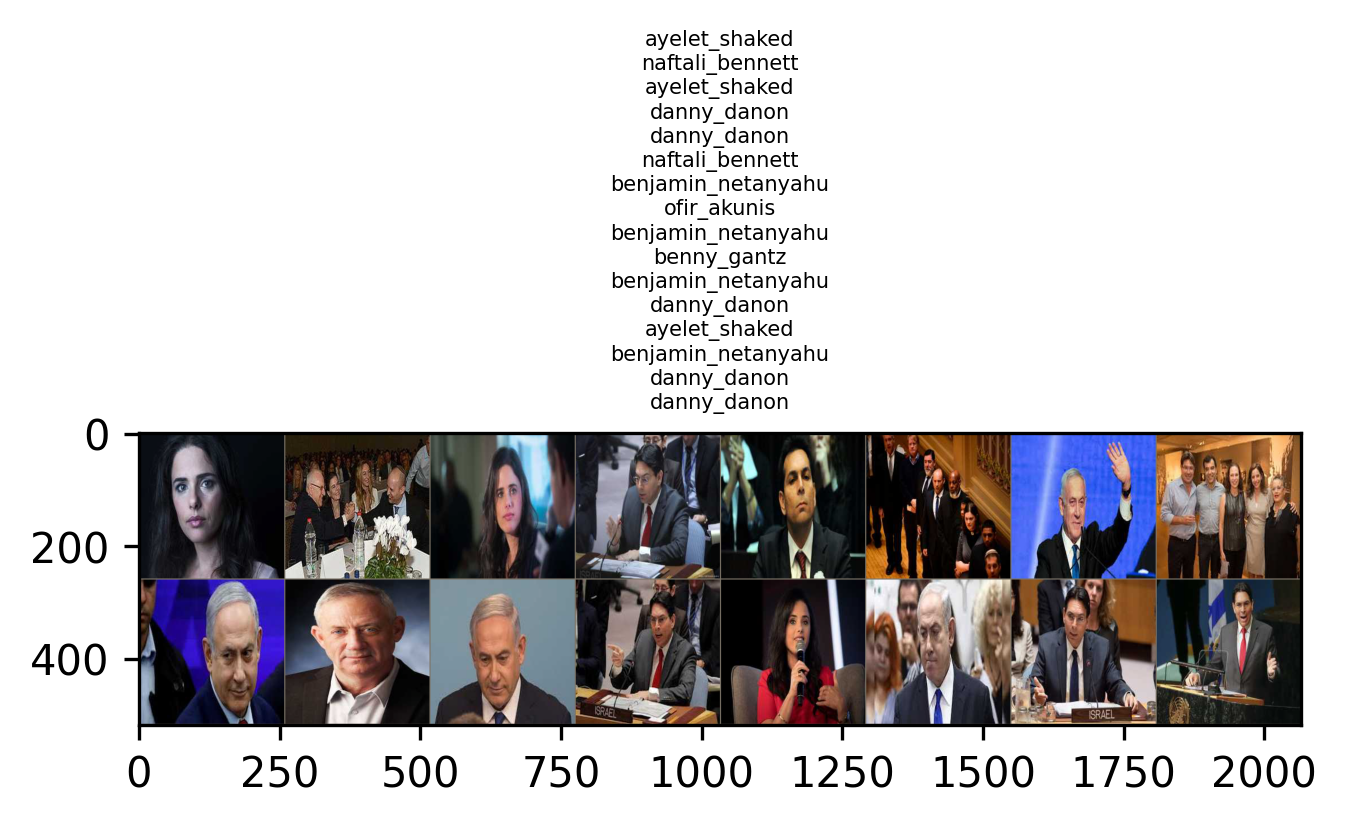

In [60]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

### Using a pretrained model
Let's load a model pretrained on ImageNet, and use it for our task.  
We will use the VGG16 network, that won the ImageNet Challenge in 2016.

In [61]:
# from IPython import display
# display.Image("./img/vgg_architecture.png")

The first time we load the model, it will be downloaded locally, and then cached for the future.

In [82]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.
model = models.vgg16(pretrained=True)

We can print the model to learn about its structure as shown below.  
In future lessons, we will learn to read this output.  
For now, we can see that it is composed of 2D Convolution layers, non-linear ReLU activation, and 2D Max pooling, followed by a few fully connected layers. 

In [83]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Keras has a useful model summary, that we can also use for PyTorch models:

In [84]:
!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
    

We can see above that the final layer is a fully connected layer, from 4096 neurons to 1000 neurons, with a total of `4096 * 1000 + 1000 = 4,097,000` parameters. We add 1000 weights for the bias term of each output neuron.  

So in total, VGG-16 has 138M parameters, and we've set them all to be trainable.

However, VGG-16 and other networks created for ImageNet all have 1,000 neurons in their output, since they classify images to one of the 1,000 categories in the ImageNet challenge.  
To use the network for our task, we need to replace the final fully-connected layer with one mapping to 9 neurons instead of 1000:

In [85]:
# This code should output the number of input neurons to the final layer. We'll use it to create a new layer instead of it.
last_layer = list(model.children())[-1]
if hasattr(last_layer, 'in_features'):
  num_ftrs = last_layer.in_features
else:
  num_ftrs = last_layer[-1].in_features

num_ftrs

4096

To access and set a layer in the network, we reference it by name. In the example above, the final layer is `model.classifier[6]`.

In [86]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

Let's now replace it with a linear layer with 4096 input features and 9 output features:

In [87]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

Let's review our change in the model:

In [88]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [89]:
summary(model.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Next, we define the loss, optimizer and LR scheduler.

In [90]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.001 and momentum
# Momentum simulates the corase of a heavy ball, and keeps moving in the direction of the previous gradient along with the new gradient. 
# Empirically it is known to show better convergence. We will learn about it in future lessons.
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [91]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_loss_and_acc = {
        'train':{'loss':[],'acc':[]},
        'val':{'loss':[],'acc':[]}

    }
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epochs_loss_and_acc[phase]['loss'].append(epoch_loss)
            epochs_loss_and_acc[phase]['acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epochs_loss_and_acc

## Finetuning the network




### Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [92]:
model, epochs_loss_and_acc = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.7992 Acc: 0.3638
val Loss: 2.2207 Acc: 0.3504

Epoch 1/9
----------
train Loss: 1.4166 Acc: 0.5102
val Loss: 1.1065 Acc: 0.6111

Epoch 2/9
----------
train Loss: 0.6910 Acc: 0.7729
val Loss: 0.8808 Acc: 0.7009

Epoch 3/9
----------
train Loss: 0.3454 Acc: 0.8924
val Loss: 1.0790 Acc: 0.6923

Epoch 4/9
----------
train Loss: 0.2209 Acc: 0.9300
val Loss: 0.9280 Acc: 0.7393

Epoch 5/9
----------
train Loss: 0.1653 Acc: 0.9440
val Loss: 0.7198 Acc: 0.7906

Epoch 6/9
----------
train Loss: 0.1286 Acc: 0.9494
val Loss: 0.8135 Acc: 0.7821

Epoch 7/9
----------
train Loss: 0.0374 Acc: 0.9903
val Loss: 0.7170 Acc: 0.8077

Epoch 8/9
----------
train Loss: 0.0194 Acc: 0.9946
val Loss: 0.7227 Acc: 0.7991

Epoch 9/9
----------
train Loss: 0.0140 Acc: 0.9978
val Loss: 0.7353 Acc: 0.8077

Training complete in 3m 24s
Best val Acc: 0.807692


### Visualizing the model predictions

Let's define a generic function to display our model's predictions for a few images:




In [93]:
def visualize_model(model, num_images=6):    
    # Record the train/evaluate mode of the model, to restore it after we're done
    was_training = model.training
    # Set the model mode to evaluate
    model.eval()
    
    images_so_far = 0
    plt.figure(figsize=(2,1), dpi=300)

    with torch.no_grad(): # No need to collect gradients when generating predictions
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        # Restore the model's train/evaluate mode
        model.train(mode=was_training)

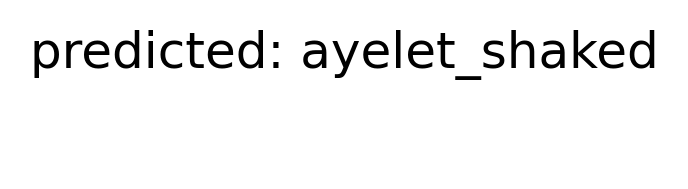

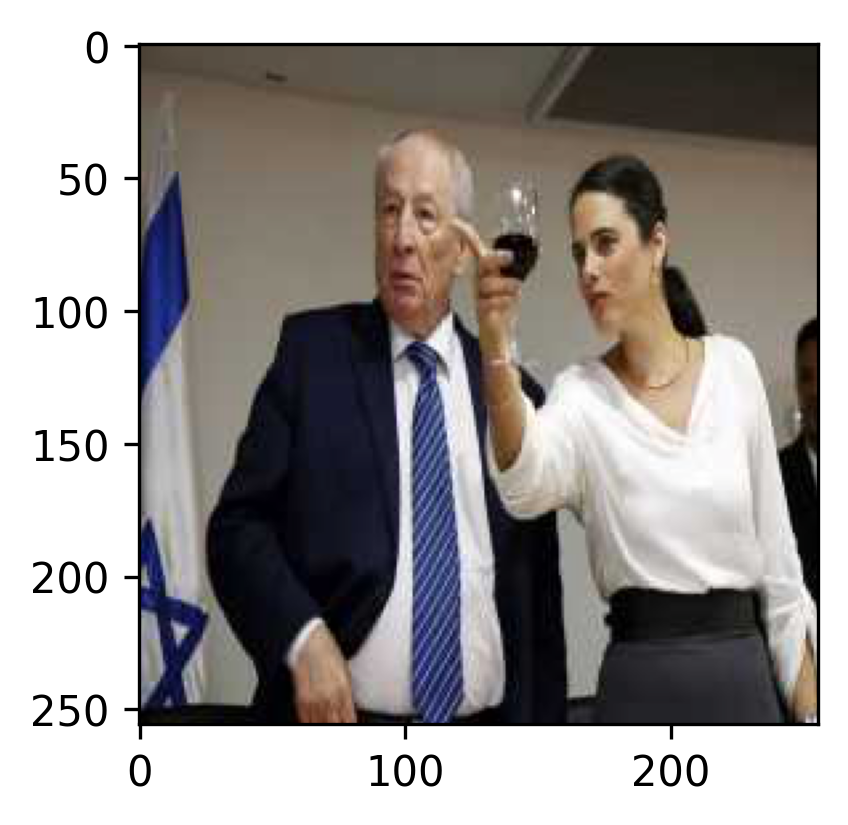

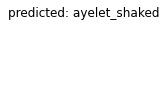

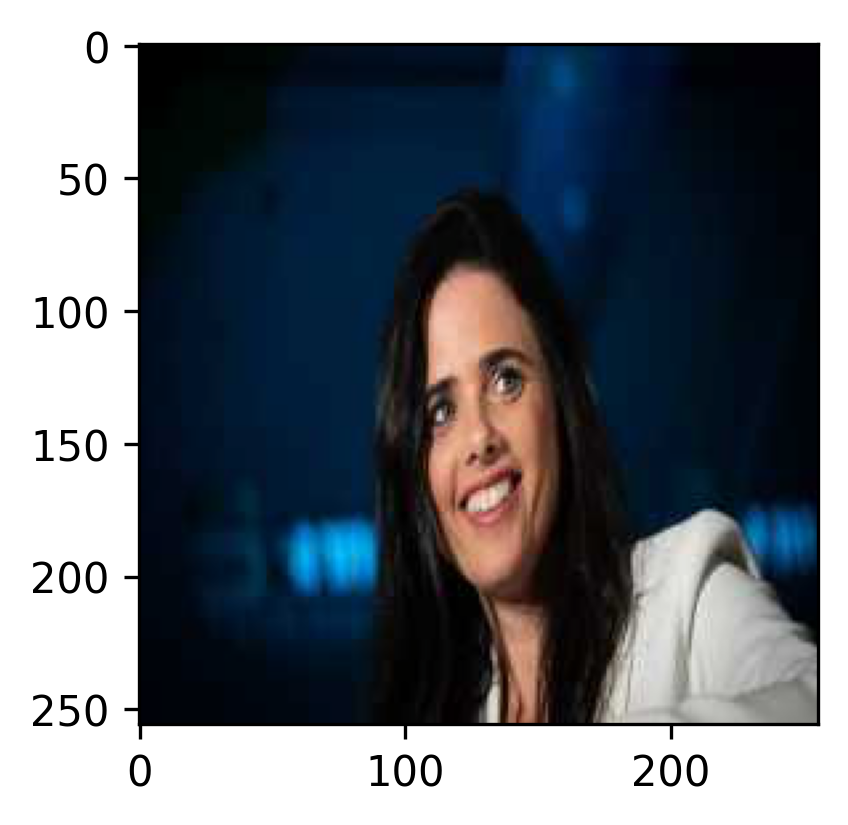

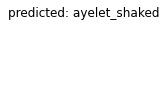

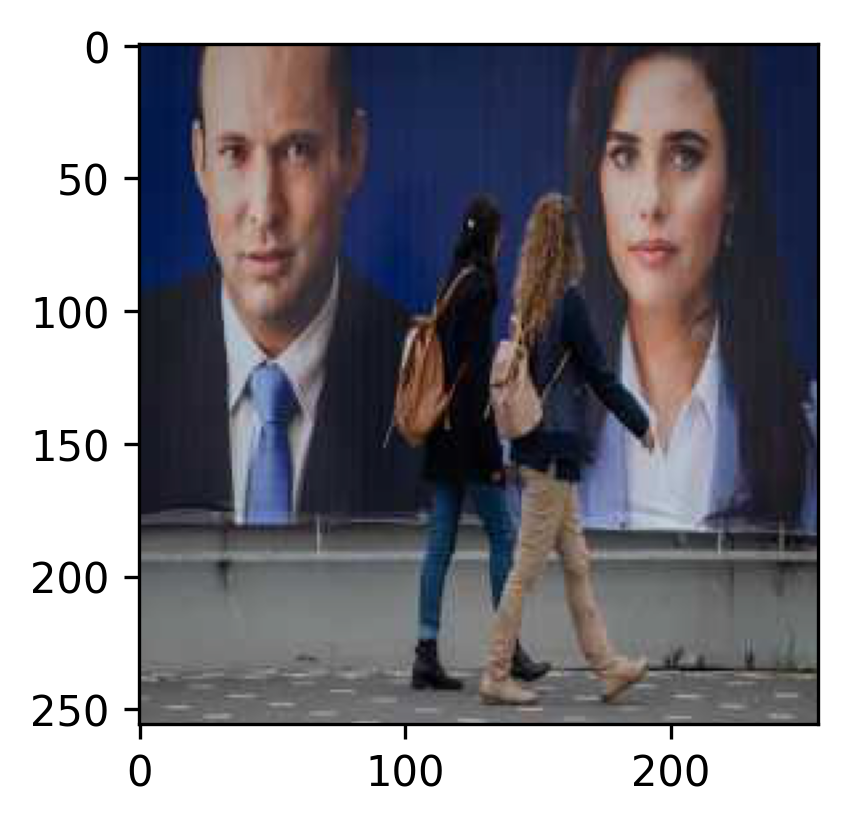

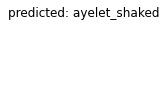

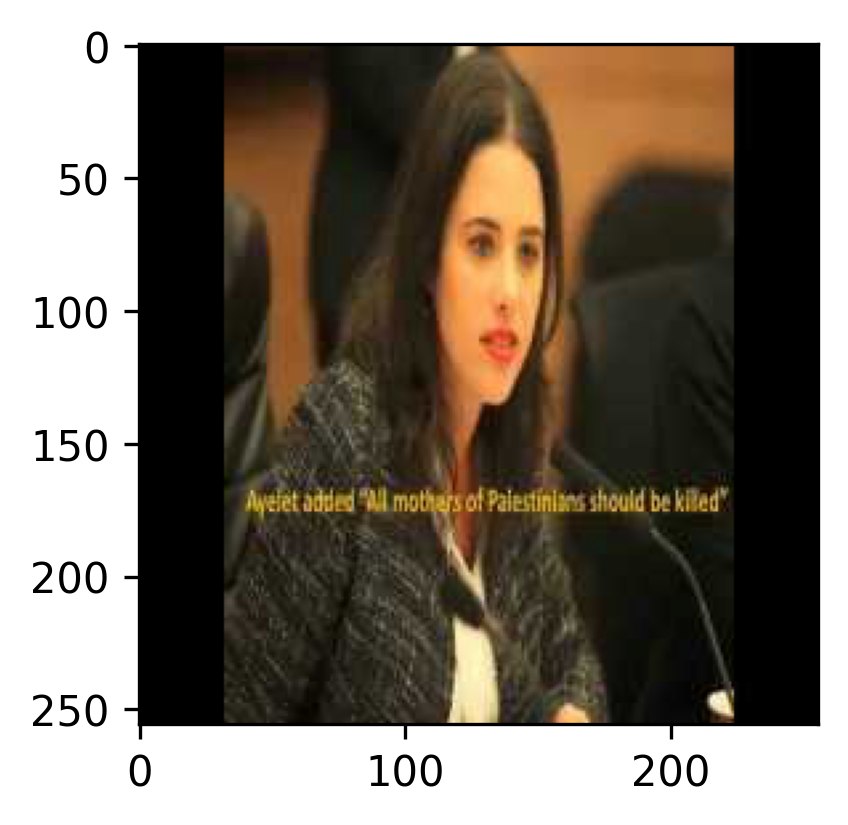

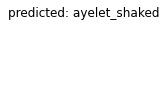

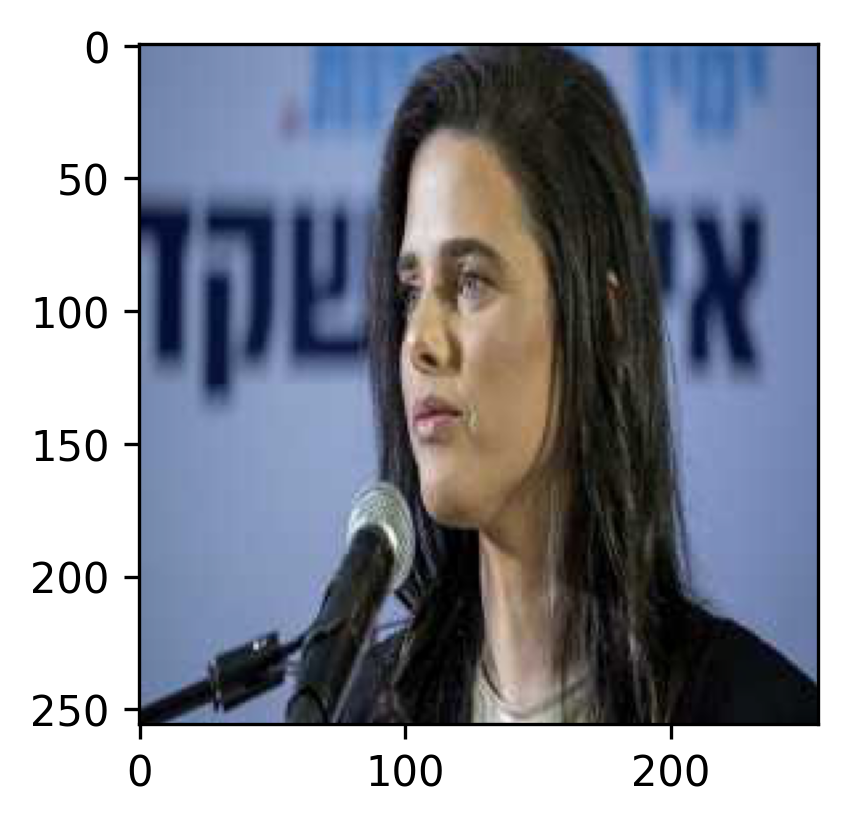

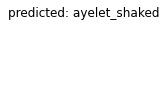

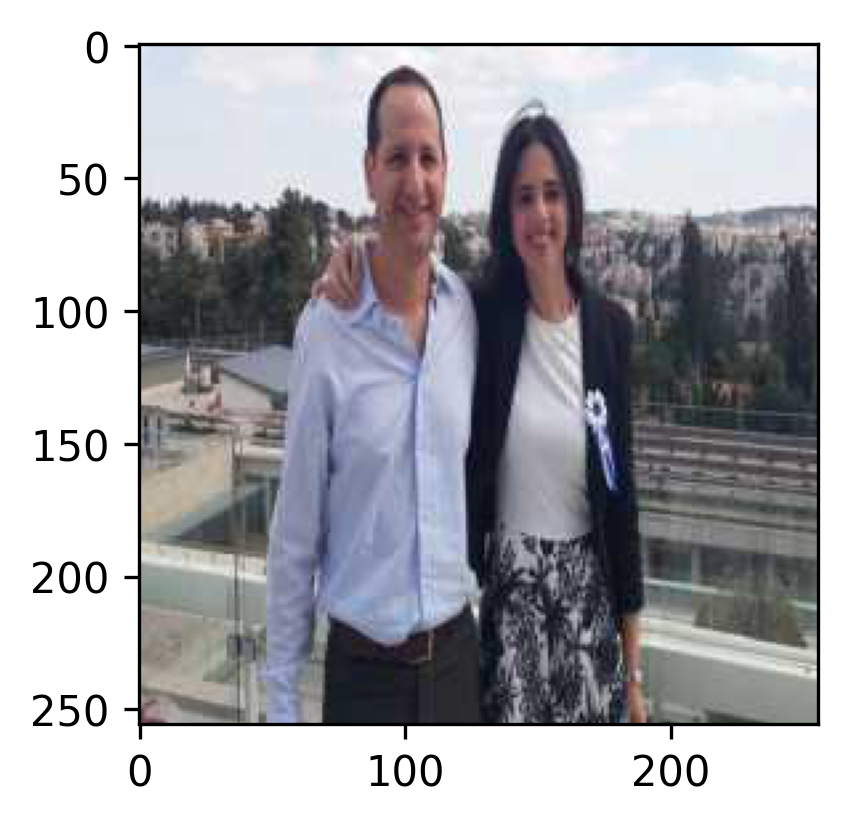

In [94]:
visualize_model(model)

# Additional Tasks
In the sections below, you'll experiment with PyTorch and NN yourself.  

Before you start having fun on your own, let's review together how to get some predictions from our trained model.  

As we've done in both our training and visualization code, we apply the model to input with the command:  
```python
outputs = model(inputs)
```

The relevant code:

In [95]:
inputs, labels = next(iter(dataloaders['train']))
inputs = inputs.to(device)
print(inputs)

labels = labels.to(device)
print(labels)

tensor([[[[-0.2513, -0.3541, -0.5596,  ..., -0.7822, -0.7479, -0.7308],
          [-0.2513, -0.3369, -0.5253,  ..., -0.7822, -0.7479, -0.7308],
          [-0.2513, -0.3198, -0.4911,  ..., -0.7822, -0.7479, -0.7308],
          ...,
          [-1.6555, -1.6727, -1.7069,  ..., -0.7993, -1.9638, -1.8953],
          [-1.6555, -1.6727, -1.7069,  ..., -0.9363, -1.7069, -1.7069],
          [-1.6555, -1.6727, -1.7069,  ..., -1.1589, -1.7412, -1.8268]],

         [[ 0.0126, -0.0924, -0.3375,  ..., -0.0574, -0.0224, -0.0049],
          [ 0.0126, -0.0749, -0.3025,  ..., -0.0574, -0.0224, -0.0049],
          [ 0.0126, -0.0574, -0.2675,  ..., -0.0574, -0.0224, -0.0049],
          ...,
          [-1.5105, -1.5105, -1.4755,  ..., -0.2675, -1.2654, -1.0378],
          [-1.5105, -1.5105, -1.4755,  ..., -0.4076, -1.0028, -0.8452],
          [-1.5105, -1.5105, -1.4755,  ..., -0.6352, -1.0378, -0.9678]],

         [[ 0.8797,  0.7751,  0.5136,  ...,  1.7685,  1.8034,  1.8208],
          [ 0.8797,  0.7925,  

Note that we got tensors. We can convert them into numpy objects. Since we've previously set them to use GPU, We'll need to set them to use CPU first:

In [96]:
labels.cpu().numpy()

array([2, 1, 1, 8, 8, 7, 3, 4, 1, 6, 6, 7, 2, 3, 1, 4])

In [97]:
outputs = model(inputs)

print(outputs.shape)
print(outputs)

torch.Size([16, 9])
tensor([[-3.4093, -1.6094, 14.4593, -4.5533,  2.4666, -2.3469, -2.4800, -2.0243,
          2.3887],
        [-5.1888, 17.3352,  0.5394, -2.2608,  0.6576, -5.1399,  0.9483, -4.8725,
         -1.1723],
        [-5.8255, 16.5101,  5.2588, -5.0629,  4.9360, -3.8453, -2.2777, -3.8507,
         -3.9656],
        [ 1.5613, -3.1154,  0.8805, -5.6078, -1.5911, -3.6264, -1.8686, -0.6993,
         14.7765],
        [ 1.8199, -7.6875,  0.7426, -4.0768,  2.0674, -0.3205, -4.5283, -1.2102,
         13.5239],
        [-2.7851, -2.8059, -2.4017,  0.8340,  1.3186,  0.1561, -3.2262, 12.2193,
         -1.8496],
        [ 1.2066, -1.0455, -1.1766,  9.0138,  0.1286, -4.5763, -1.4708,  1.2909,
         -1.7497],
        [-5.0935, -3.7516,  1.7425,  1.6733, 18.5642,  0.6506, -4.2309, -2.7607,
         -2.6994],
        [-7.3040, 20.4222,  3.4754, -4.1562, -0.5137, -6.9157, -0.9538, -3.6045,
         -0.0702],
        [ 0.5319, -0.7195,  1.1401,  0.3582, -1.1784, -3.7119,  9.4592, -3.1383,

Note that `outputs` have 16 "rows", one for each of the images in our batch, and each "row" has 9 values, for each of our classes.  
The values are the activations of the neurons, before applying the softmax function to them. To apply the softmax function to them, we can run:

In [98]:
torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()

array([[1.73684729e-08, 1.05064636e-07, 9.99987841e-01, 5.53293589e-09,
        6.18918602e-06, 5.02522610e-08, 4.39916086e-08, 6.93885411e-08,
        5.72533327e-06],
       [1.65182548e-10, 9.99999762e-01, 5.07775830e-08, 3.08714854e-09,
        5.71468739e-08, 1.73445938e-10, 7.64304318e-08, 2.26624705e-10,
        9.16848197e-09],
       [1.99412958e-10, 9.99977589e-01, 1.29899245e-05, 4.27541030e-10,
        9.40629343e-06, 1.44469292e-09, 6.92755187e-09, 1.43693490e-09,
        1.28093069e-09],
       [1.82254450e-06, 1.69676131e-08, 9.22595063e-07, 1.40343182e-09,
        7.79143292e-08, 1.01784075e-08, 5.90355711e-08, 1.90066601e-07,
        9.99996901e-01],
       [8.26061023e-06, 6.13749884e-10, 2.81296047e-06, 2.27053683e-08,
        1.05798381e-05, 9.71483360e-07, 1.44551393e-08, 3.99087810e-07,
        9.99976873e-01],
       [3.04566697e-07, 2.98289251e-07, 4.46866750e-07, 1.13609594e-05,
        1.84452820e-05, 5.76783032e-06, 1.95936167e-07, 9.99962449e-01,
        7.7

## Task 1: Plot model convergence
Adapt the code above to plot the loss and the accuracy every epoch. Show both the training and the validation performance.  
Does our model overfit?  
Do you have suggestions following these graphs? 

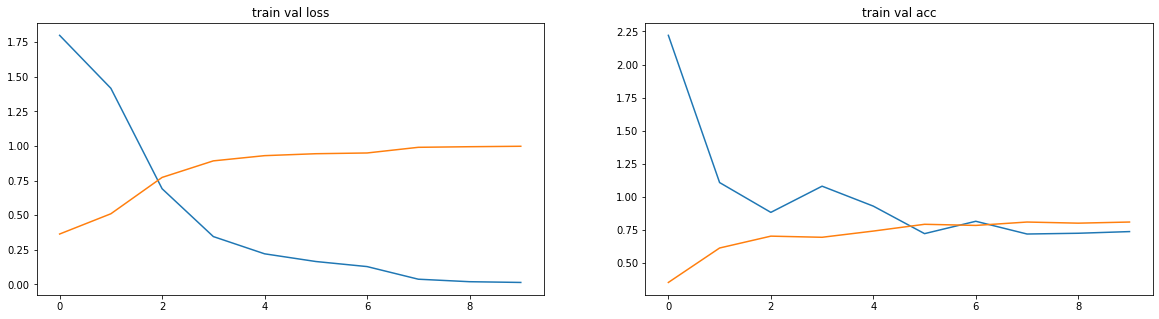

In [99]:
# Create a grid of subplots
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# title for the plots
# Set-up grid for plotting.

ax[0].plot(epochs_loss_and_acc['train']['loss'], )
ax[0].plot(epochs_loss_and_acc['train']['acc'], )
ax[0].set_title('train val loss')

ax[1].plot(epochs_loss_and_acc['val']['loss'], )
ax[1].plot(epochs_loss_and_acc['val']['acc'], )
ax[1].set_title('train val acc')

plt.show()


**Does our model overfit?** Yes

Suggestions:
* Increase data samples
* stop after 2 epochs

## Task 2: Evaluate the model performance
Write code that shows the performance of our model.  
Show the classification report and the confusion matrix.  

What can you say about the model so far?  
Can you suggest a few ideas to improve it?

In [ ]:
model

In [123]:
from sklearn.metrics import classification_report
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

In [125]:
preds_ = preds.cpu().numpy()

In [126]:
labels_ = labels.cpu().numpy()

In [139]:
class_names

['ayelet_shaked',
 'benjamin_netanyahu',
 'benny_gantz',
 'danny_danon',
 'gideon_saar',
 'kostya_kilimnik',
 'naftali_bennett',
 'ofir_akunis',
 'yair_lapid']

In [141]:
class_names_ = np.array(class_names)[[1,2,3,4,6,7,8]]
class_names_

array(['benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar',
       'naftali_bennett', 'ofir_akunis', 'yair_lapid'], dtype='<U18')

In [142]:
print(classification_report(labels_, preds_, target_names=class_names_))

                    precision    recall  f1-score   support

benjamin_netanyahu       1.00      1.00      1.00         4
       benny_gantz       1.00      1.00      1.00         2
       danny_danon       1.00      1.00      1.00         2
       gideon_saar       1.00      1.00      1.00         2
   naftali_bennett       1.00      1.00      1.00         2
       ofir_akunis       1.00      1.00      1.00         2
        yair_lapid       1.00      1.00      1.00         2

          accuracy                           1.00        16
         macro avg       1.00      1.00      1.00        16
      weighted avg       1.00      1.00      1.00        16



<AxesSubplot:>

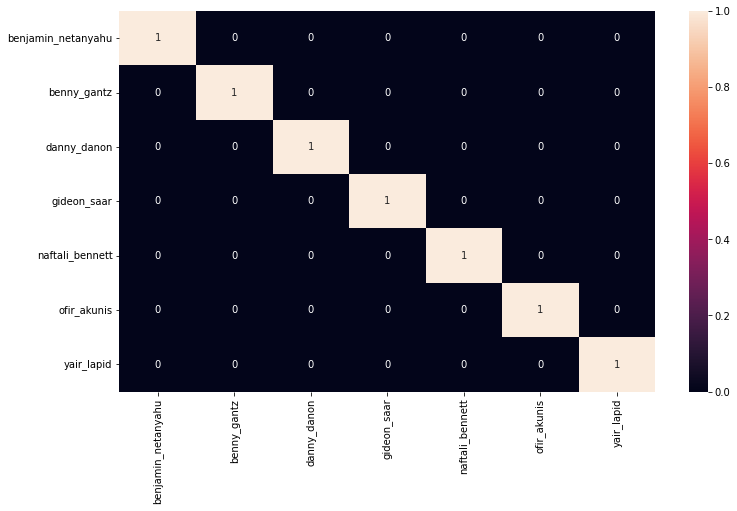

In [143]:
# Build confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(labels_, preds_)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in class_names_],
                     columns = [i for i in class_names_])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

## Task 3: Perform Error Analysis 
Error Analysis is an extremely important practice in Machine Learning research. It is rare that our base model works great out of the box. Proper error analysis helps us detect and fix issues in our DL code, data preprocessing and even in the data itself.

#### Review examples of top errors
One of the basic techniques of Error Analysis is manually reviewing the top errors of the model - samples where the model was most confident about one class, but the true label was different.  
Plot the top 10 errors of the model for each true class.  
Do you spot any issue or pattern?  
Try to see if you can improve the performance of the model following your insights.

## Task 4: Data Augmentation
Manually labeling can be expensive, both in terms of money and of time. Data augmentations serve to increase the amount of data available for the classifier without requiring labeling more images.  

The torch vision package allows easy augmentation of images using the data transforms.  
Use and adapt the code below to try different augmentations, and discuss the results and the model improvements you got from these augmentations.

[This guide](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/) might help you along the way.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

model = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                    num_epochs=num_epochs)

## Task 5: Model Architectures
In the course we'll cover in depth various DL architectures suggested to perform image classification. Among other things, these networks differ in depth (the number of layers), the number of weights (the network power), the composing layers, and more.  
In the figure below, you can see the performance of different network architectures on the ImageNet Image Classification task, and the number of flops (atomic computations) required for them. 

![CNN performance/flops graph](https://miro.medium.com/max/1838/1*n16lj3lSkz2miMc_5cvkrA.jpeg)

In our code above we've used the `VGG` architecture.  
See if you can increase model performance by using alternative architectures from [torchvision.models](https://pytorch.org/vision/0.8/models.html).  
Pay attention to the input dimensions that each network architecture expects.

## (bonus) Task 6: Design your own Neural Network Architecture
Take a stab at building your own NN architecture.  
To allow you to experiment quickly, we'll limit it to 8 layers max, and up to 10 million parameters. Use [this PyTorch guide](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) for reference.  
Train it only on our provided images - we'll present the winner with the best results on the validation set!